In [1]:
import gym
from gym import spaces
import os
import gc
import torch
import pygame
import numpy as np
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [3]:


class FrozenLakeEnv(gym.Env):
    def __init__(self, grid):
        super(FrozenLakeEnv, self).__init__()
        self.grid = grid
        self.grid_height = len(grid)
        self.grid_width = len(grid[0])
        [self.start_y], [self.start_x] = np.where(np.array(grid) == 'S')
        self.slip_probability = 1/3 # Probability to slip to one side (so the chance of slipping in any direction is 2 times this value)
        assert self.slip_probability <= 1/2
        self.action_space = spaces.Discrete(4)  # Left, Down, Right, Up
        self.observation_space = spaces.Discrete(self.grid_height * self.grid_width)

        self.state_action_count = {}
        for x in range(self.grid_width):
            for y in range(self.grid_height):
                self.state_action_count[(x, y)] = {0: 0, 1: 0, 2: 0, 3: 0}

    def reset(self):
        # Top left corner is 0, 0
        self.state = (self.start_x, self.start_y)
        return self.to_observation(self.state)
    
    def step(self, action):
        self.state_action_count[self.state][action] += 1
        x, y = self.state

        # Define possible actions for each chosen direction
        # Make sure the first action in the array is the action itself (no slip)
        possible_actions = {
                0: [0, 3, 1],  # Left
                1: [1, 0, 2],  # Down
                2: [2, 1, 3],  # Right
                3: [3, 2, 0]   # Up
            }            

        # Choose a random action from the possible actions according to self.slip_probability
        p = self.slip_probability
        action = np.random.choice(possible_actions[action], p=[1-2*p, p, p])
        # print("Actual action", ["left", "down", "right", "up"][action])

        # Move in the chosen direction if its within bounds
        if action == 0 and x > 0:
            x -= 1
        elif action == 1 and y < self.grid_height - 1:
            y += 1
        elif action == 2 and x < self.grid_width - 1:
            x += 1
        elif action == 3 and y > 0:
            y -= 1

        self.state = (x, y)
        reward = 0
        done = False

        # Check state of the cell
        if self.grid[y][x] == 'X':
            reward = -5
            done = True
        elif self.grid[y][x] == 'G':
            reward = 10
            done = True

        return self.to_observation(self.state), reward, done, {}

    def to_observation(self, state):
        x, y = state
        return y * self.grid_width + x

    def render(self):
        grid = np.full((self.grid_height, self.grid_width), ' ')
        for y in range(self.grid_height):
            for x in range(self.grid_width):
                grid[y, x] = self.grid[y][x]
        x, y = self.state
        grid[y, x] = 'A'
        print('\n'.join(' '.join(row) for row in grid))
        print()

def make_frozenlake(grid):
    return FrozenLakeEnv(grid)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Used for debugging; CUDA related errors shown immediately.

# Seed everything for reproducible results
seed = 2024
np.random.seed(seed)
np.random.default_rng(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

cuda


In [45]:

class ReplayMemory:
    def __init__(self, capacity):
        """
        Experience Replay Memory defined by deques to store transitions/agent experiences
        """
        
        self.capacity = capacity
        
        self.states       = deque(maxlen=capacity)
        self.actions      = deque(maxlen=capacity)
        self.next_states  = deque(maxlen=capacity)
        self.rewards      = deque(maxlen=capacity)
        self.dones        = deque(maxlen=capacity)
        
        
    def store(self, state, action, next_state, reward, done):
        """
        Append (store) the transitions to their respective deques
        """
        
        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.dones.append(done)
        
        
    def sample(self, batch_size):
        """
        Randomly sample transitions from memory, then convert sampled transitions
        to tensors and move to device (CPU or GPU).
        """
        
        indices = np.random.choice(len(self), size=batch_size, replace=False)

        states = torch.stack([torch.as_tensor(self.states[i], dtype=torch.float32, device=device) for i in indices]).to(device)
        actions = torch.as_tensor([self.actions[i] for i in indices], dtype=torch.long, device=device)
        next_states = torch.stack([torch.as_tensor(self.next_states[i], dtype=torch.float32, device=device) for i in indices]).to(device)
        rewards = torch.as_tensor([self.rewards[i] for i in indices], dtype=torch.float32, device=device)
        dones = torch.as_tensor([self.dones[i] for i in indices], dtype=torch.bool, device=device)

        return states, actions, next_states, rewards, dones
    
    
    def __len__(self):
        """
        To check how many samples are stored in the memory. self.dones deque 
        represents the length of the entire memory.
        """
        
        return len(self.dones)
    
    
class DQN_Network(nn.Module):
    """
    The Deep Q-Network (DQN) model for reinforcement learning.
    This network consists of Fully Connected (FC) layers with ReLU activation functions.
    """
    
    def __init__(self, num_actions, input_dim):
        """
        Initialize the DQN network.
        
        Parameters:
            num_actions (int): The number of possible actions in the environment.
            input_dim (int): The dimensionality of the input state space.
        """
        
        super(DQN_Network, self).__init__()
                                                          
        self.FC = nn.Sequential(
            nn.Linear(input_dim, 12),
            nn.ReLU(inplace=True),
            nn.Linear(12, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, num_actions)
            )
        
        # Initialize FC layer weights using He initialization
        for layer in [self.FC]:
            for module in layer:
                if isinstance(module, nn.Linear):
                    nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
        
        
    def forward(self, x):
        """
        Forward pass of the network to find the Q-values of the actions.
        
        Parameters:
            x (torch.Tensor): Input tensor representing the state.
        
        Returns:
            Q (torch.Tensor): Tensor containing Q-values for each action.
        """
        
        Q = self.FC(x)    
        return Q
    
        
class DQN_Agent:
    """
    DQN Agent Class. This class defines some key elements of the DQN algorithm,
    such as the learning method, hard update, and action selection based on the
    Q-value of actions or the epsilon-greedy policy.
    """
    
    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay, 
                  clip_grad_norm, learning_rate, discount, memory_capacity):
        
        # To save the history of network loss
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0
                     
        # RL hyperparameters
        self.epsilon_max   = epsilon_max
        self.epsilon_min   = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.discount      = discount

        self.action_space  = env.action_space
        self.action_space.seed(seed) # Set the seed to get reproducible results when sampling the action space 
        self.observation_space = env.observation_space
        self.replay_memory = ReplayMemory(memory_capacity)
        
        # Initiate the network models
        self.main_network = DQN_Network(num_actions=self.action_space.n, input_dim=self.observation_space.n).to(device)
        self.target_network = DQN_Network(num_actions=self.action_space.n, input_dim=self.observation_space.n).to(device).eval()
        self.target_network.load_state_dict(self.main_network.state_dict())

        self.clip_grad_norm = clip_grad_norm # For clipping exploding gradients caused by high reward value
        self.critertion = nn.MSELoss()
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=learning_rate)
                

    def select_action(self, state):
        """
        Selects an action using epsilon-greedy strategy OR based on the Q-values.
        
        Parameters:
            state (torch.Tensor): Input tensor representing the state.
        
        Returns:
            action (int): The selected action.
        """
        
        # Exploration: epsilon-greedy
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()
        
        # Exploitation: the action is selected based on the Q-values.    
        with torch.no_grad():
            Q_values = self.main_network(state)
            action = torch.argmax(Q_values).item()
                        
            return action
   

    def learn(self, batch_size, done, current_steps):
        """
        Train the main network using a batch of experiences sampled from the replay memory.
        
        Parameters:
            batch_size (int): The number of experiences to sample from the replay memory.
            done (bool): Indicates whether the episode is done or not. If done,
            calculate the loss of the episode and append it in a list for plot.
        """ 
        
        # Sample a batch of experiences from the replay memory
        states, actions, next_states, rewards, dones = self.replay_memory.sample(batch_size)
                    
        
        # # The following prints are for debugging. Use them to indicate the correct shape of the tensors.
        # print('Before--------Before')
        # print("states:", states.shape)
        # print("actions:", actions.shape)
        # print("next_states:", next_states.shape)
        # print("rewards:", rewards.shape)
        # print("dones:", dones.shape)
               
         
        # # Preprocess the data for training
        # states        = states.unsqueeze(1)
        # next_states   = next_states.unsqueeze(1)
        actions       = actions.unsqueeze(1)
        rewards       = rewards.unsqueeze(1)
        dones         = dones.unsqueeze(1)       
        
        
        # # The following prints are for debugging. Use them to indicate the correct shape of the tensors.
        # print()
        # print('After--------After')
        # print("states:", states.shape)
        # print("actions:", actions.shape)
        # print("next_states:", next_states.shape)
        # print("rewards:", rewards.shape)
        # print("dones:", dones.shape)
      
        
        predicted_q = self.main_network(states) # forward pass through the main network to find the Q-values of the states
        predicted_q = predicted_q.gather(dim=1, index=actions) # selecting the Q-values of the actions that were actually taken

        # Compute the maximum Q-value for the next states using the target network
        with torch.no_grad():            
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0] # not argmax (cause we want the maxmimum q-value, not the action that maximize it)
            
        
        next_target_q_value[dones] = 0 # Set the Q-value for terminal states to zero
        y_js = rewards + (self.discount * next_target_q_value) # Compute the target Q-values
        loss = self.critertion(predicted_q, y_js) # Compute the loss
        
        # Update the running loss and learned counts for logging and plotting
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            episode_loss = self.running_loss / self.learned_counts # The average loss for the episode
            self.loss_history.append([current_steps, episode_loss]) # Append the episode loss to the loss history for plotting
            # Reset the running loss and learned counts
            self.running_loss = 0
            self.learned_counts = 0
            
        self.optimizer.zero_grad() # Zero the gradients
        loss.backward() # Perform backward pass and update the gradients
        
        # # Uncomment the following two lines to find the best value for clipping gradient (Comment torch.nn.utils.clip_grad_norm_ while uncommenting the following two lines)
        # grad_norm_before_clip = torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), float('inf'))
        # print("Gradient norm before clipping:", grad_norm_before_clip)
        
        # Clip the gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
        
        self.optimizer.step() # Update the parameters of the main network using the optimizer
 

    def hard_update(self):
        """
        Navie update: Update the target network parameters by directly copying 
        the parameters from the main network.
        """
        
        self.target_network.load_state_dict(self.main_network.state_dict())

    
    def update_epsilon(self):
        """
        Update the value of epsilon for epsilon-greedy exploration.
        
        This method decreases epsilon over time according to a decay factor, ensuring
        that the agent becomes less exploratory and more exploitative as training progresses.
        """
        
        self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_decay)
        

    def save(self, path):
        """
        Save the parameters of the main network to a file with .pth extention.
        
        """
        torch.save(self.main_network.state_dict(), path)
                  

class Model_TrainTest:
    def __init__(self, hyperparams):
        
        # Define RL Hyperparameters
        self.train_mode             = hyperparams["train_mode"]
        self.RL_load_path           = hyperparams["RL_load_path"]
        self.save_path              = hyperparams["save_path"]
        self.save_interval          = hyperparams["save_interval"]
        
        self.clip_grad_norm         = hyperparams["clip_grad_norm"]
        self.learning_rate          = hyperparams["learning_rate"]
        self.discount_factor        = hyperparams["discount_factor"]
        self.batch_size             = hyperparams["batch_size"]
        self.update_frequency       = hyperparams["update_frequency"]
        self.max_episodes           = hyperparams["max_episodes"]
        self.max_steps_episode      = hyperparams["max_steps_episode"]
        self.max_steps              = hyperparams["max_steps"]
        self.render                 = hyperparams["render"]
        
        self.epsilon_max            = hyperparams["epsilon_max"]
        self.epsilon_min            = hyperparams["epsilon_min"]
        self.epsilon_decay          = hyperparams["epsilon_decay"]
        
        self.memory_capacity        = hyperparams["memory_capacity"]
        
        self.num_states             = hyperparams["num_states"]
        # self.map_size               = hyperparams["map_size"]
        self.map                    = hyperparams["map"]
        self.render_fps             = hyperparams["render_fps"]
                        
        # Define Env
        # self.env = gym.make('FrozenLake-v1', map_name=f"{self.map_size}x{self.map_size}", 
        #                     is_slippery=False, max_episode_steps=self.max_steps, 
        #                     render_mode="human" if self.render else None)
        
        self.env = make_frozenlake(self.map)
        self.env.metadata['render_fps'] = self.render_fps # For max frame rate make it 0
        
        # Define the agent class
        self.agent = DQN_Agent(env                = self.env, 
                                epsilon_max       = self.epsilon_max, 
                                epsilon_min       = self.epsilon_min, 
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity)
        
        self.n_bins = 100
        self.loss_bins = []
        self.result_bins = []
                
        
    def state_preprocess(self, state:int, num_states:int):
        """
        Convert an state to a tensor and basically it encodes the state into 
        an onehot vector. For example, the return can be something like tensor([0,0,1,0,0]) 
        which could mean agent is at state 2 from total of 5 states.

        """
        onehot_vector = torch.zeros(num_states, dtype=torch.float32, device=device)
        onehot_vector[state] = 1
        return onehot_vector
    
    
    def train(self): 
        """                
        Reinforcement learning training loop.
        """
        # self.agent = DQN_Agent(env                = self.env, 
        #                         epsilon_max       = self.epsilon_max, 
        #                         epsilon_min       = self.epsilon_min, 
        #                         epsilon_decay     = self.epsilon_decay,
        #                         clip_grad_norm    = self.clip_grad_norm,
        #                         learning_rate     = self.learning_rate,
        #                         discount          = self.discount_factor,
        #                         memory_capacity   = self.memory_capacity)
        
        total_steps = 0
        episode = 0
        self.reward_history = []
        self.agent = DQN_Agent(env                = self.env, 
                                epsilon_max       = self.epsilon_max, 
                                epsilon_min       = self.epsilon_min, 
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity)
        
        # Training loop over episodes
        while total_steps < self.max_steps and episode < self.max_episodes:
            # state, _ = self.env.reset(seed=seed)
            state = self.env.reset()
            state = self.state_preprocess(state, num_states=self.num_states)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0
                                                
            while not done and not truncation:
                action = self.agent.select_action(state)
                # next_state, reward, done, truncation, _ = self.env.step(action)
                next_state, reward, done, truncation = self.env.step(action)
                next_state = self.state_preprocess(next_state, num_states=self.num_states)
                
                self.agent.replay_memory.store(state, action, next_state, reward, done) 
                # print(sum(self.reward_history))
                # if len(self.agent.replay_memory) > self.batch_size and sum(self.reward_history) > 0: This was the original but since we have a negative reward so the sum doesn't work the same way anymore
                if len(self.agent.replay_memory) > self.batch_size:
                    self.agent.learn(self.batch_size, (done or truncation), total_steps + step_size)
                
                    # Update target-network weights
                    if total_steps % self.update_frequency == 0:
                        self.agent.hard_update()
                    
                
                state = next_state
                episode_reward += reward
                step_size +=1
                            
            # Appends for tracking history
            self.reward_history.append(episode_reward) # episode reward                        
            total_steps += step_size
            episode += 1
                                                                           
            # Decay epsilon at the end of each episode
            self.agent.update_epsilon()
                            
            # #-- based on interval
            # if episode % self.save_interval == 0:
            #     self.agent.save(self.save_path + '_' + f'{episode}' + '.pth')
            #     if episode != self.max_episodes:
            #         self.plot_training(episode)
            #     print('\n~~~~~~Interval Save: Model saved.\n')
    
            # result = (f"Episode: {episode}, "
            #           f"Total Steps: {total_steps}, "
            #           f"Ep Step: {step_size}, "
            #           f"Raw Reward: {episode_reward:.2f}, "
            #           f"Epsilon: {self.agent.epsilon_max:.2f}")
            
            result = (f"Episode: {episode}, "
                      f"Total Steps: {total_steps}, "
                      f"Raw Reward: {episode_reward:.2f}, ")
            print(result)
            self.result_bins.append([total_steps,episode_reward])
        self.loss_bins += self.agent.loss_history
                                                                    

    def test(self, max_episodes):  
        """                
        Reinforcement learning policy evaluation.
        """
           
        # Load the weights of the test_network
        self.agent.main_network.load_state_dict(torch.load(self.RL_load_path))
        self.agent.main_network.eval()
        
        # Testing loop over episodes
        for episode in range(1, max_episodes+1):         
            # state, _ = self.env.reset(seed=seed)
            state = self.env.reset()
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0
                                                           
            while not done and not truncation:
                state = self.state_preprocess(state, num_states=self.num_states)
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                                
                state = next_state
                episode_reward += reward
                step_size += 1
                                                                                                                       
            # Print log            
            result = (f"Episode: {episode}, "
                      f"Steps: {step_size:}, "
                      f"Reward: {episode_reward:.2f}, ")
            print(result)
            
        pygame.quit() # close the rendering window
           
    def map_tuples_to_bins(self, tuples):
        bins = np.linspace(0, self.max_steps, self.n_bins + 1)  # Create bins
        bin_elements = [[] for _ in range(self.n_bins)]  # Initialize lists for each bin
    
        for t in tuples:
            # Find the bin index for the first number in the tuple
            bin_index = np.digitize(min(t[0], self.max_steps - 1) * 1.0, bins) - 1
            # Add the second number in the tuple to the appropriate bin
            bin_elements[bin_index].append(t[1])
    
        return bin_elements
    
    
    def plot_training(self):
        rewards_binned = self.map_tuples_to_bins(self.result_bins)
        avgs = []
        stdvs = []
        for bin in rewards_binned:
            avgs.append(np.mean(bin))
            stdvs.append(np.std(bin))
        avgs = np.array(avgs)
        stdvs = np.array(stdvs)
        
        bin_size = self.max_steps //  self.n_bins 
        bins = np.arange(0, self.max_steps, bin_size)
        
        plt.figure(figsize=(10, 6))
        plt.plot(bins, avgs, label='Average', color='blue')
        plt.fill_between(bins, avgs - stdvs, avgs + stdvs, color='blue', alpha=0.2, label='Standard Deviation')
        
        plt.xlabel('Environment steps')
        plt.ylabel('Reward')
        plt.title('Reward over time (binned)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        loss_binned = self.map_tuples_to_bins(self.loss_bins)
        # print(loss_binned)
        avgs = []
        stdvs = []
        for bin in loss_binned:
            avgs.append(np.mean(bin))
            stdvs.append(np.std(bin))
        avgs = np.array(avgs)
        stdvs = np.array(stdvs)
        
        bin_size = self.max_steps //  self.n_bins 
        bins = np.arange(0, self.max_steps, bin_size)
        
        plt.figure(figsize=(10, 6))
        plt.plot(bins, avgs, label='Average', color='blue')
        plt.fill_between(bins, avgs - stdvs, avgs + stdvs, color='blue', alpha=0.2, label='Standard Deviation')
        
        plt.xlabel('Environment steps')
        plt.ylabel('Loss')
        plt.title('Loss over time (binned)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_training_old(self, episode):
        # Calculate the Simple Moving Average (SMA) with a window size of 50
        sma = np.convolve(self.reward_history, np.ones(50)/50, mode='valid')
        
        plt.figure()
        plt.title("Rewards")
        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()
        
        # Only save as file if last episode
        if episode == self.max_episodes:
            plt.savefig('./reward_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close() 
        
                
        plt.figure()
        plt.title("Loss")
        plt.plot(self.agent.loss_history, label='Loss', color='#CB291A', alpha=1)
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        
        # Only save as file if last episode
        if episode == self.max_episodes:
            plt.savefig('./Loss_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()        
        

In [5]:
no_aleatoric_uncertainty_3x3 = [
    ['S', '.', '.'],
    ['.', '.', '.'],
    ['.', '.', 'G']
]

safe_3x3 = [
    ['S', 'X', '.'],
    ['.', '.', '.'],
    ['.', '.', 'G']
]

long_safe_4x3 = [
    ['S', 'X', 'G'],
    ['.', 'X', '.'],
    ['.', 'X', '.'],
    ['.', '.', '.']
]

short_unsafe_long_safe_4x3 = [
    ['S', 'X', 'G'],
    ['.', '.', '.'],
    ['.', 'X', '.'],
    ['.', '.', '.']
]

unsafe_path_safe_area_3x4 = [
    ['S', '.', 'X', '.'],
    ['.', '.', '.', '.'],
    ['.', '.', 'X', 'G']
]

random_test_4x4 = [
    ['S', '.', 'X'],
    ['.', '.', '.'],
    ['.', 'X', '.'],
    ['.', '.', 'G']
]

In [47]:
# Parameters:
train_mode = True

render = not train_mode
# map_size = 4 # 4x4 or 8x8 (outdated)
map_mame = "long_safe_4x3"
RL_hyperparams = {
    "train_mode"            : train_mode,
    "RL_load_path"          : f'./level_stats/{map_mame}/final_weights' + '_' + '3000' + '.pth',
    "save_path"             : f'./level_stats/{map_mame}/final_weights',
    "save_interval"         : 500,
    
    "clip_grad_norm"        : 3,
    "learning_rate"         : 6e-4,
    "discount_factor"       : 0.93,
    "batch_size"            : 32,
    "update_frequency"      : 10,
    "max_episodes"          : 8000           if train_mode else 5,
    "max_steps"             : 50000,
    "max_steps_episode"     : 200,
    "render"                : render,
    
    "epsilon_max"           : 0.999         if train_mode else -1,
    "epsilon_min"           : 0.01,
    "epsilon_decay"         : 0.999,
    
    "memory_capacity"       : 4_000        if train_mode else 0,
        
    # "map_size"              : map_size,
    "num_states"            : len(long_safe_4x3) * len(long_safe_4x3[0]),    # 3 rows in your example
    "map"                   : long_safe_4x3,
    "render_fps"            : 6
    }


# Run
DRL = Model_TrainTest(RL_hyperparams) # Define the instance
# Train
if train_mode:
    for i in range(10):
        DRL.train()
    DRL.plot_training()
else:
    # Test
    DRL.test(max_episodes = RL_hyperparams['max_episodes'])

C:\Users\filip\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Episode: 1, Total Steps: 2, Raw Reward: -5.00, 
Episode: 2, Total Steps: 6, Raw Reward: -5.00, 
Episode: 3, Total Steps: 8, Raw Reward: -5.00, 
Episode: 4, Total Steps: 17, Raw Reward: -5.00, 
Episode: 5, Total Steps: 19, Raw Reward: -5.00, 
Episode: 6, Total Steps: 27, Raw Reward: -5.00, 
Episode: 7, Total Steps: 28, Raw Reward: -5.00, 
Episode: 8, Total Steps: 32, Raw Reward: -5.00, 
Episode: 9, Total Steps: 35, Raw Reward: -5.00, 
Episode: 10, Total Steps: 37, Raw Reward: -5.00, 
Episode: 11, Total Steps: 39, Raw Reward: -5.00, 
Episode: 12, Total Steps: 40, Raw Reward: -5.00, 
Episode: 13, Total Steps: 44, Raw Reward: -5.00, 
Episode: 14, Total Steps: 47, Raw Reward: -5.00, 
Episode: 15, Total Steps: 48, Raw Reward: -5.00, 
Episode: 16, Total Steps: 60, Raw Reward: -5.00, 
Episode: 17, Total Steps: 62, Raw Reward: -5.00, 
Episode: 18, Total Steps: 66, Raw Reward: -5.00, 
Episode: 19, Total Steps: 68, Raw Reward: -5.00, 
Episode: 20, Total Steps: 70, Raw Reward: -5.00, 
Episode: 21,

KeyboardInterrupt: 

# Aleatoric Uncertainty

I'm trying to calculate aleatoric uncertainty, essentially the following code just calculates the square root of the variance of the rewards for each state action pair ($\sqrt{\mathbb{V}[r]}$). this reveals a $m \times n \times 4$ array. I lowkey forgot the other variance he told us, it was along the lines of $\sqrt{\mathbb{V}[r + \gamma x]}$? I don't fully remember. 

I was thinking as well maybe using the Q-values from the DQN and use the variance of that instead? this will have to be discussed.

In [6]:
def calculate_aleatoric_uncertainty(env, num_simulations=1000):
    
    uncertainty = np.zeros((env.grid_height, env.grid_width, 4))  # mxnx4

    #x and y for each position in the grid
    for y in range(env.grid_height):
        for x in range(env.grid_width):
            for action in range(4):
                rewards = []
                #simulate
                for _ in range(num_simulations):
                    env.reset()  #reset environment to initial state
                    env.state = (x, y)  #set state manually to (x, y)
                    if env.grid[y][x] == 'X' or env.grid[y][x] == 'G':
                        break
                    _, reward, _, _ = env.step(action)
                    # print(env.state)
                    # print(env.render())
                    # print(reward)
                    rewards.append(reward)

                #calculate variance 
                uncertainty[y, x, action] = np.var(rewards)
                # print(np.sqrt(uncertainty))

    return np.sqrt(uncertainty)

In [7]:
env = make_frozenlake(long_safe_4x3)
uncertainty_array = calculate_aleatoric_uncertainty(env)
print("\nFinal Uncertainty:")
print(uncertainty_array)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Final Uncertainty:
[[[0.         2.35819846 2.32058182 2.32456448]
  [       nan        nan        nan        nan]
  [       nan        nan        nan        nan]]

 [[0.         2.37022678 2.31451399 2.37355746]
  [       nan        nan        nan        nan]
  [6.19644253 2.35995233 4.61666546 6.2554756 ]]

 [[0.         2.34373633 2.37684139 2.34924988]
  [       nan        nan        nan        nan]
  [2.34742412 2.33811356 0.         2.38168008]]

 [[0.         0.         0.         0.        ]
  [2.39557404 0.         2.35995233 2.35106359]
  [0.         0.         0.         0.        ]]]


In [8]:

uncertainty_left = uncertainty_array[:, :, 0]   #left
uncertainty_down = uncertainty_array[:, :, 1]   #down
uncertainty_right = uncertainty_array[:, :, 2]  #right
uncertainty_up = uncertainty_array[:, :, 3]     #up


print("Uncertainty for moving Left:")
print(uncertainty_left)
print("\nUncertainty for moving Down:")
print(uncertainty_down)
print("\nUncertainty for moving Right:")
print(uncertainty_right)
print("\nUncertainty for moving Up:")
print(uncertainty_up)



Uncertainty for moving Left:
[[0.                nan        nan]
 [0.                nan 6.19644253]
 [0.                nan 2.34742412]
 [0.         2.39557404 0.        ]]

Uncertainty for moving Down:
[[2.35819846        nan        nan]
 [2.37022678        nan 2.35995233]
 [2.34373633        nan 2.33811356]
 [0.         0.         0.        ]]

Uncertainty for moving Right:
[[2.32058182        nan        nan]
 [2.31451399        nan 4.61666546]
 [2.37684139        nan 0.        ]
 [0.         2.35995233 0.        ]]

Uncertainty for moving Up:
[[2.32456448        nan        nan]
 [2.37355746        nan 6.2554756 ]
 [2.34924988        nan 2.38168008]
 [0.         2.35106359 0.        ]]


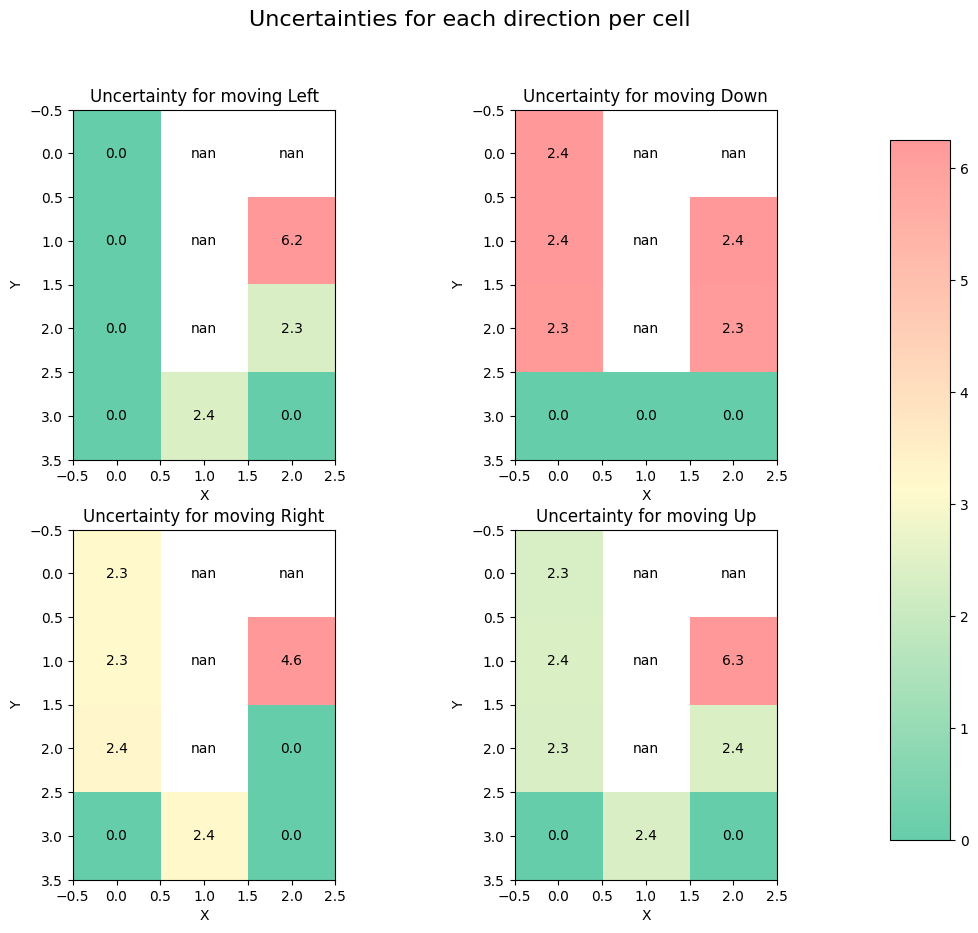

In [9]:

colours = [(0, "#66cdaa"), (0.5, "#fffacd"), (1, "#ff9999")]
cmap = mcolors.LinearSegmentedColormap.from_list("stoplight", colours)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Uncertainties for each direction per cell', fontsize=16)

titles = ['Left', 'Down', 'Right', 'Up']
uncertainties = [uncertainty_left, uncertainty_down, uncertainty_right, uncertainty_up]
for ax, title, data in zip(axs.flat, titles, uncertainties):
    im = ax.imshow(data, cmap=cmap, origin='upper', interpolation='nearest')
    ax.set_title(f'Uncertainty for moving {title}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    for (j, i), value in np.ndenumerate(data):
        ax.text(i, j, f'{value:.1f}', ha='center', va='center', color='black')

plt.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7]) 
fig.colorbar(im, cax=cbar_ax, orientation='vertical')

plt.show()


# Plotting the outcome distribution

I did this since I wanted to see whether my simulating was correct, but this honestly could also be used since if you can then fit a distribution to the inherent stochastic nature of the environment you could try to infer the uncertainty.

In [42]:
def model_outcome_distributions(env, num_simulations=1000):
    outcomes = np.empty((env.grid_height, env.grid_width, 4), dtype=object)
    
    #store outcomes
    for y in range(env.grid_height):
        for x in range(env.grid_width):
            for action in range(4):
                outcomes[y, x, action] = []

    #x and y for each position in the grid
    for y in range(env.grid_height):
        for x in range(env.grid_width):
            for action in range(4):
                #simulate
                for _ in range(num_simulations):
                    env.reset()  #reset environment to initial state
                    env.state = (x, y)  #set state manually to (x, y)
                    _, reward, _, _ = env.step(action)
                    outcomes[y, x, action].append(reward)
    return outcomes

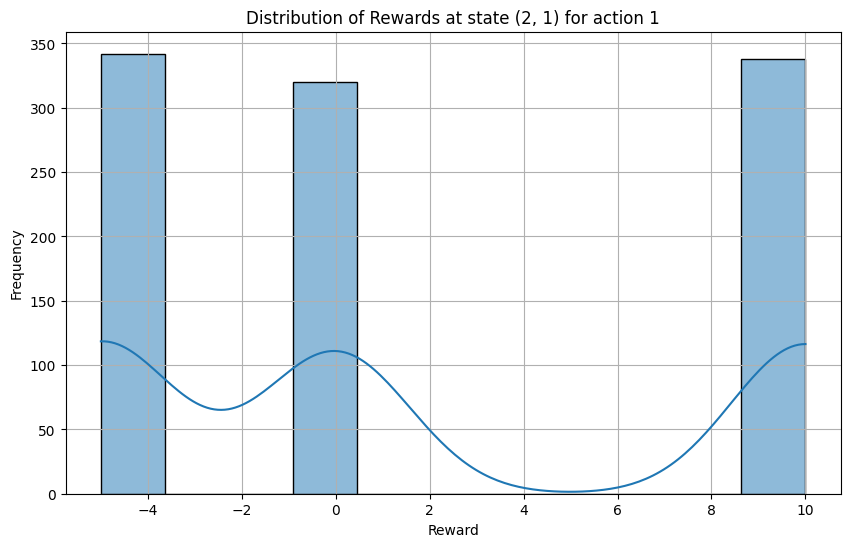

In [43]:
def plot_distribution(env, outcomes, x, y, action):
    # Select the list of rewards for the specified state-action pair
    data = outcomes[y, x, action]
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True)
    plt.title(f"Distribution of Rewards at state ({x}, {y}) for action {action}")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


grid = [
    ['S', 'X', '.'],
    ['.', 'X', '.'],
    ['.', '.', 'G']
]
env = make_frozenlake(grid)
outcomes = model_outcome_distributions(env)

plot_distribution(env, outcomes, 2, 1, 1)